In [3]:
using DataFrames,PythonPlot,StatsBase,Random,Distributions,CSV,DSP
PythonPlot.svg(true)
include("model.jl")
include("formulas.jl")

FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/figures"

"/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/figures"

In [4]:
data= CSV.read("./output/sho_data_cells_1d.csv",DataFrame);
data
ω0range = data.ω0 |> unique |> sort;
ηrange = data.η |> unique |> sort;
nuxrange = data.uθ |> unique |> sort;
data.nux = data.uθ; # add nux column for clarity

In [17]:
# check we are getting physical solutions
dfu = data[data.nux .== nuxrange[2],:]
P = hcat([[d.isphys[1] for d in groupby(dfuet, :η)] for dfuet in groupby(dfu, :ω0)]...)
minimum(P) # should be 1

1

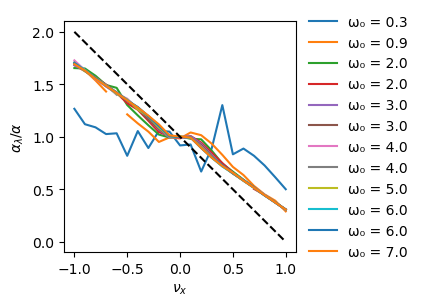

In [18]:
fig,axs = subplots(figsize=(3, 3),sharex=true)

ax = axs #[0]
η =  ηrange[end]
j = 0
for ω0 in ω0range[2:3:end]
    df = data[(data.η .== η) .& (data.ω0 .== ω0), :]
    α = [-cov(d.ϕ, d.z0) / var(d.z0) for d in groupby(df, :nux)]
    αλ = [-cov(d.ϕ ./ d.τ, d.z0) / var(d.z0) * mean(d.τ) for d in groupby(df, :uθ)]
    ax.plot(nuxrange,αλ ./α,"C$(j)-",label = "ω₀ = $(round(ω0; sigdigits=1))")
    j = j+ 1
end
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5),frameon=false)
#ax.set_ylim([0,1.2])
#ax.legend()
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
ax.plot(nuxrange,1 .- nuxrange,"k--")
ax.set_ylabel("\$\\alpha_{\\lambda}/\\alpha \$")

# ax = axs[1]
# η =  ηrange[end]
# j = 0
# for ω0 in ω0range[10:10:end]
#     df = data[(data.η .== η) .& (data.ω0 .== ω0), :]
#     ρ = [-cov(d.λ[2:end], d.λ[1:end-1]) / var(d.λ) for d in groupby(df, :q)]
#     ax.plot(qrange,ρ,"C$(j)-",label="ω0 = $(ω0)")
#     j = j+ 1
# end

ax.set_xlabel(L"$\nu_x$")
fig

# Coarse-grained paramaters (Fig 3 A)

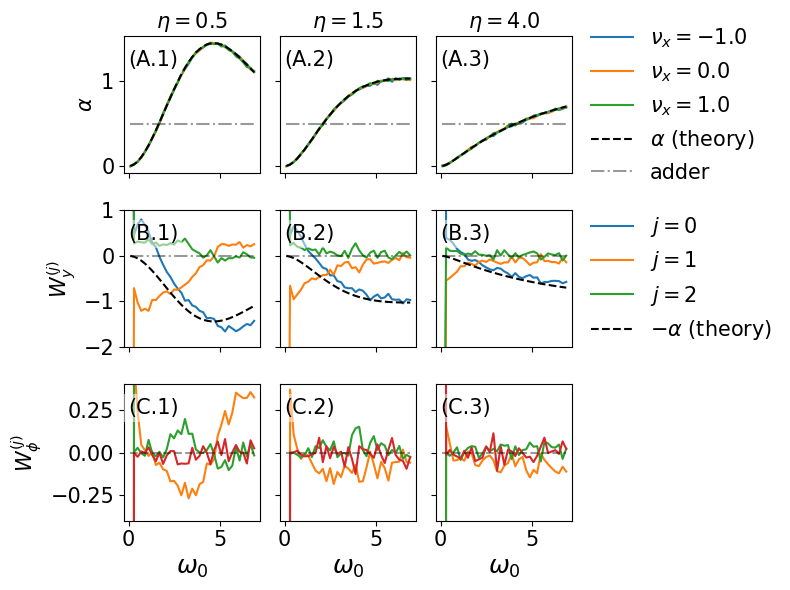

In [19]:
fig, axs = subplots(figsize=(8, 6), ncols=length(ηrange), nrows=3, sharey="row", sharex=true)

l = 3
row_labels = ["A", "B", "C"]
for i in 1:length(ηrange)
    η = ηrange[i]
    nux = 0

    for row in 1:3
        ax = axs[row-1, i-1]
        # Add panel label in the upper right corner, not bold, with white background and large font
        ax.text(0.4, 0.9, "($(row_labels[row]).$(i))", transform=ax.transAxes, fontsize=15, va="top", ha="right", bbox=Dict("facecolor"=>"white","alpha"=>0.5, "edgecolor"=>"none", "pad"=>2.5))
        ax.tick_params(labelsize=15)
    end

    # Row 1: alpha
    ax = axs[0, i-1]
    for j in 1:10:length(nuxrange)
        dfcell = data[(data.η .== η) .& (data.nux .== nuxrange[j]), :]
        alphas = [-cov(df.ϕ, df.z0) / var(df.z0) for df in groupby(dfcell, :ω0)]
        ax.plot(ω0range, alphas, "-", label="\${\\nu_{x}}=$(nuxrange[j])\$")
    end
    ax.plot(ω0range, [alpha_SHO(η * ω0, ω0, 1/log(2), η) for ω0 in ω0range], "k--", label="\$\\alpha\$ (theory)")
    ax.plot(ω0range, 0.5 .* ones(length(ω0range)), "k-.", alpha=0.4, label="adder")
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

    # Row 2: W_z0
    ax = axs[1, i-1]
    Wz0s = []
    Wz0s_theory = []
    dfcell = data[(data.η .== η) .& (data.nux .== nuxrange[end]), :]
    for k in 1:length(ω0range)
        d = dfcell[dfcell.ω0 .== ω0range[k], :]
        push!(Wz0s, coarse_grained1D(d, l)[2])
        push!(Wz0s_theory, W_theory(η, ω0range[k], 1/log(2), l)[2])
    end
    Wz0s = hcat(Wz0s...)
    Wz0s_theory = hcat(Wz0s_theory...)
    [ax.plot(ω0range, Wz0s[j, :], "-", label="\$j=$(j-1)\$") for j in 1:l]
    # [ax.plot(ω0range, Wz0s_theory[j, :], "k--") for j in 1:size(Wz0s_theory, 1)]
    ax.plot(ω0range, [-alpha_SHO(η * ω0, ω0, 1/log(2), η) for ω0 in ω0range], "k--", label="\$-\\alpha\$ (theory)")
    ax.plot(ω0range, zeros(length(ω0range)), "k-.", alpha=0.4)
    ax.set_ylim(-2, 1)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

    # Row 3: W_z0
    ax = axs[2, i-1]
    Wz0s = []
    dfcell = data[(data.η .== η) .& (data.nux .== nuxrange[end]), :]
    for k in 1:length(ω0range)
        d = dfcell[dfcell.ω0 .== ω0range[k], :]
        push!(Wz0s, coarse_grained1D(d, l)[1])
    end
    Wz0s = hcat(Wz0s...)
    [ax.plot(ω0range, Wz0s[j, :], "C$(j)-", label="\$j=$(j)\$") for j in 1:size(Wz0s, 1)]
    ax.plot(ω0range, zeros(length(ω0range)), "k--", alpha=0.4)
    ax.set_xlabel(L"$\omega_0$")
    ax.set_ylim(-0.4, 0.4)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

end

# Add legend ONLY on the middle row, first column
axs[0,2].legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=false, fontsize=15)
axs[1,2].legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=false, fontsize=15)
axs[0,0].set_ylabel("\$\\alpha\$", fontsize=15)
axs[1,0].set_ylabel("\$W_{y}^{(j)}\$", fontsize=15)
axs[2,0].set_ylabel("\$W_{\\phi}^{(j)}\$", fontsize=15)
# plot titles starting etarange
for i in 1:length(ηrange)
    axs[0, i-1].set_title("\$\\eta = $(ηrange[i])\$", fontsize=15)
end

tight_layout()
savefig(joinpath(FIG_PATH, "fig2_cg.pdf"), bbox_inches="tight", pad_inches=0, format="pdf")
fig

## Plots of 

In [41]:
fig,ax = subplots(figsize=(4,4))
dfcell = data[(data.η .== ηrange[5]) .& (data.ω0 .== ω0range[3]), :]
alphas = [-cov(df.ϕ, df.z0) / var(df.z0) for df in groupby(dfcell, :nux)]
ax.plot(nuxrange, alphas, ".-", label="\${\\nu_{x}}=$(nuxrange[j])\$")

dfcell = data[(data.η .== ηrange[end]) .& (data.ω0 .== ω0range[10]), :]
alphas = [-cov(df.ϕ, df.z0) / var(df.z0) for df in groupby(dfcell, :nux)]
ax.plot(nuxrange, alphas, ".-", label="\${\\nu_{x}}=$(nuxrange[j])\$")
ax.set_ylim([-0.1,0.9])
fig

BoundsError: BoundsError: attempt to access 3-element Vector{Float64} at index [5]

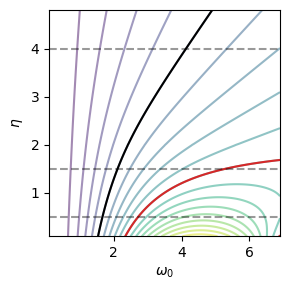

In [7]:

ηrange_ = collect(0.1:0.02:1.2ηrange[end])
ω0range_ = collect(0.1:0.02:ω0range[end])

# Preallocate
alpha_vals = zeros(length(ω0range_), length(ηrange_))

# Populate the matrix
for (i, ω0) in enumerate(ω0range_)
    for (j, η) in enumerate(ηrange_)
        alpha_vals[i, j] = alpha_SHO(η * ω0, ω0, 1 / log(2), η)
    end
end

# Transpose for correct orientation in PyPlot
alpha_vals_t = alpha_vals'

# Set contour levels
vmin = minimum(alpha_vals_t)
vmax = maximum(alpha_vals_t)
levels = range(vmin, vmax, length=20)

# Plot
fig, ax = subplots(figsize=(3, 3))


cs = ax.contour(ω0range_,ηrange_,alpha_vals_t,levels=20,alpha=0.5)
cs = ax.contour(ω0range_,ηrange_,alpha_vals_t,levels=[0.5], colors="k", linewidths=1.5, linestyles="-")
cs = ax.contour(ω0range_,ηrange_,alpha_vals_t,levels=[1.0], colors="C3", linewidths=1.5, linestyles="-")
#ax.clabel(cs,cs.levels, inline=true, fontsize=8)
#ax.semilogy()

ax.plot(ω0range_, ones(length(ω0range_))*ηrange[1], "k--",alpha=0.4)
ax.plot(ω0range_, ones(length(ω0range_))*ηrange[2], "k--",alpha=0.4)
ax.plot(ω0range_, ones(length(ω0range_))*ηrange[3], "k--",alpha=0.4)

# Label contours


# Labels and title
ax.set_xlabel(L"\omega_0")
ax.set_ylabel(L"\eta")
savefig(joinpath(FIG_PATH, "fig2_contour.pdf"), bbox_inches="tight", pad_inches=0.1, format="pdf")
tight_layout()
fig